In [44]:
import pandas as pd
import numpy as np
import maddpkg
import matplotlib.pyplot as plt
import pickle

In [45]:
model = "NB"
sensitive_feature = "gender"

In [46]:
y_pp = pickle.load(open("./data_EDM23_b/y_pp_" + model + "_" + sensitive_feature, "rb"))
X_test = pd.read_csv("./data_courseBBB/X_test_stClick_7030.csv")

## Generation of h based on m

MAYBE GENERATE 1,000 m INSTEAD OF 500?
(like in `madd_h_for_simu.ipynb`?)

In [47]:
m = np.arange(1, 500, 1)
e = 1/m
e = e[::-1]

In [48]:
madd = [maddpkg.MADD(X_test, y_pp, sensitive_feature, ei) for ei in e]

## MADD min

In [49]:
madd_min_ind = np.argmin(madd)
print("MADD minimum:", madd[madd_min_ind])
print("e associated:", e[madd_min_ind])

MADD minimum: 0.0
e associated: 1.0


## Orders of h

In [50]:
n0 = len(X_test[X_test[sensitive_feature] == 0])
n1 = len(X_test[X_test[sensitive_feature] == 1])
order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
print(n0)
print(n1)
print(order)

1404
186
0.21546010543476263


In [51]:
h_inf = 0.01*order
h_mid = 0.1*order
print(h_inf)
print(h_mid)

0.002154601054347626
0.021546010543476265


In [52]:
if h_inf > e[0]:
    ind_e_inf = np.where(e <= h_inf)[0][-1]
else:
    ind_e_inf = 0
ind_e_mid = np.where(e <= h_mid)[0][-1]
ind_e_sup_or_ind_order = np.where(e <= order)[0][-1]

## MADD(h) on [0, 1]

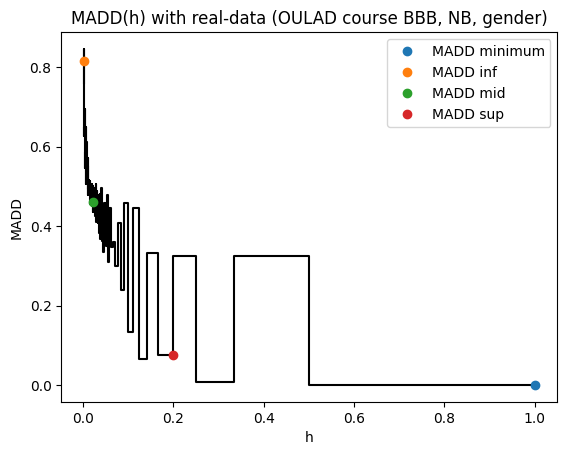

In [53]:
plt.step(e, madd, color="black")
plt.plot(e[madd_min_ind], madd[madd_min_ind], "o", label="MADD minimum")
plt.plot(e[ind_e_inf], madd[ind_e_inf], "o", label="MADD inf")
plt.plot(e[ind_e_mid], madd[ind_e_mid], "o", label="MADD mid")
plt.plot(e[ind_e_sup_or_ind_order], madd[ind_e_sup_or_ind_order], "o", label="MADD sup")
plt.xlabel("h")
plt.ylabel("MADD")
plt.title("MADD(h) with real-data (OULAD course BBB, " + model + ", " + sensitive_feature + ")")
plt.legend()

## MADD(e) focus on [0, 1]*optimal order

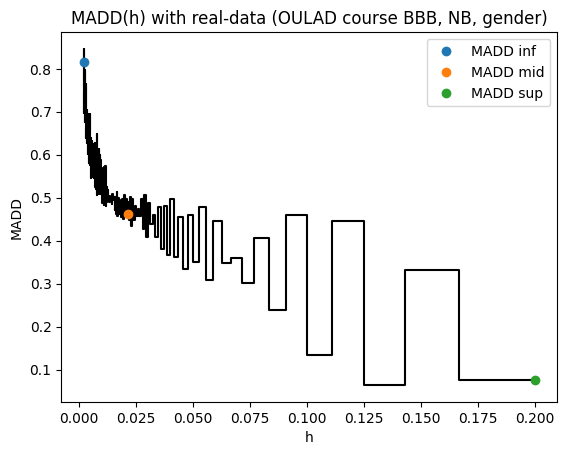

In [54]:
plt.step(e[:ind_e_sup_or_ind_order+1], madd[:ind_e_sup_or_ind_order+1], where="pre", color="black")
plt.plot(e[:ind_e_sup_or_ind_order+1][ind_e_inf], madd[:ind_e_sup_or_ind_order+1][ind_e_inf], "o", label="MADD inf")
plt.plot(e[:ind_e_sup_or_ind_order+1][ind_e_mid], madd[:ind_e_sup_or_ind_order+1][ind_e_mid], "o", label="MADD mid")
plt.plot(e[:ind_e_sup_or_ind_order+1][ind_e_sup_or_ind_order], madd[:ind_e_sup_or_ind_order+1][ind_e_sup_or_ind_order], "o", label="MADD sup")
plt.xlabel("h")
plt.ylabel("MADD")
plt.title("MADD(h) with real-data (OULAD course BBB, " + model + ", " + sensitive_feature + ")")
plt.legend()

In [55]:
ind_cv = np.where(e< 0.025)[0][-1]

In [56]:
madd[ind_cv]

0.4488558036945134

## Mean on [0, 1]*optimal order

In [57]:
np.mean(madd[ind_e_mid:ind_e_sup_or_ind_order])

0.41121264239543803

## Advanced interval selection

In [58]:
def calculate_std(y, start, end):
    """Calculates the standard deviation in the index interval [start, end] of y.
    
    Parameters
    ----------
    y : List or np.ndarray of shape (n, 1)
        The list of data in which to calculate the standard deviation
    start : int
        The initial index
    end : int
        The final index

    Returns
    -------
    float
        The standard deviation
    """
    if type(start) is int and type(end) is int:
        if start > end:
            raise Exception("start should be inferior than end.")
        if end >= len(y):
            raise Exception("end should not be greater than len(y) - 1.")
    else:
        raise Exception("start and end should be integers.")
    
    return np.std(y[start:end+1])


def find_stable_interval(h_list, madd_list, n0=None, n1=None, min_interval_length=None, min_nb_points=50):
    """Finds the bandwidth interval within which the MADD results are stable.
    Calls calculate_std().
    
    Parameters
    ----------
    h_list : List or np.ndarray of shape (n, 1)
        The list of bandwidth values
    madd_list : List or np.ndarray of shape (n, 1)
        The list of MADD results
    n0 : int
        The number of samples in the group 0
    n1 : int
        The number of samples in the group 1
    min_interval_length : float
        The minimum length for the bandwidth interval to consider
    min_nb_points : int
        The minimum number of points to consider in the bandwidth interval
    
    Returns
    -------
    dict
        Dictionary of the results
    """
    # if n0 and n1 are given, min_interval_length is automatically calculated (even if given)
    # otherwise, min_interval_length is set either to the given value or to a default value
    if type(n0) is int and type(n1) is int:
        order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
        min_interval_length = order * (1 - 0.1) / 2
    elif n0 is None or n1 is None:
        if min_interval_length is None:
            min_interval_length = 0.05
    else:
        raise Exception('n0 and n1 arguments must be both None or both int.')

    # initialize the variables
    min_std = float('inf')
    indexes = (0, 0)
    max_h = h_list[-1]

    for i in range(0, len(madd_list)):
        
        x_start = h_list[i]
        
        # if the x_start is too big, we stop the loop
        if x_start > max_h - min_interval_length:
            break
        
        # find the index of the greatest x that is smaller than x_stop
        x_min_sup = x_start + min_interval_length
        index_min_sup = np.searchsorted(h_list, x_min_sup, side='right') - 1
        
        # if the number of points in the interval is too small, we continue the loop
        if index_min_sup - i < min_nb_points:
            continue
        
        # we calculate the std of the interval [i, j]
        for j in range(index_min_sup, len(madd_list)):
            std = calculate_std(madd_list, i, j)
            if std < min_std:
                min_std = std
                indexes = (i, j)

    result = {'min interval length': min_interval_length,
              'indexes': indexes, 
              'h interval': "[{start}, {end}]".format(start=round(h_list[indexes[0]], 3),
                                                      end=round(h_list[indexes[1]+1], 3)), 
              'min madd std': min_std, 
              'madd average': np.average(madd_list[indexes[0] : indexes[1]+1])
             }
    return result


def plot_stable_interval(h_list, madd_list, show_stable=True, indexes=None, show_order=False, 
                         n0=None, n1=None, zoom="None", legend=True, ylim=None,
                        yaxis=None):
    """Plots MADD results according to the bandwidth.
    
    Parameters
    ----------
    h_list : List or np.ndarray of shape (n, 1)
        The list of bandwidth values
    madd_list : List or np.ndarray of shape (n, 1)
        The list of MADD results
    show_stable : boolean
        To show the stable interval or not
    indexes : tuple
        The indexes (initial, final) of the stable interval (to compute with find_stable_interval())
    show_order : boolean
        To show informational bandwidth values or not
    n0 : int
        The number of samples in the group 0
    n1 : int
        The number of samples in the group 1
    zoom : str or tuple
        To specify some zoom options
    legend : boolean
        To show the legend or not
    
    Returns
    -------
    None
    """
    if show_stable is True:
        if indexes is None:
            raise Exception("indexes argument should be given when show_stable=True.")
    
    if show_order is True:
        if n0 is None or n1 is None:
            raise Exception('n0 and n1 arguments must be given when show_order=True.')
    
    if zoom != "None":
        if n0 is None or n1 is None:
            raise Exception('n0 and n1 arguments must be given when zoom is not "None".')
        elif zoom == "stable":
            if indexes is None:
                raise Exception('indexes argument should be given when zoom is "stable".')

    if type(n0) is int and type(n0) is int:
        order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)

    plt.step(h_list, madd_list, where="pre", color="black")
    #plt.plot(h_list, madd_list, color="black")
    
    if show_stable:
        plt.axvline(x=h_list[indexes[0]], color="g", linestyle="--")
        plt.axvline(x=h_list[indexes[1]], color="g", linestyle="--")
        plt.axhline(y=np.average(madd_list[indexes[0]:indexes[1]+1]), color="g", linestyle="--", label="MADD average in the stable interval ({0})".format(round(np.average(madd_list[indexes[0] : indexes[1]+1]), 2)))
        if legend is True:
            plt.legend()

    if zoom == "None":
        plt.xlim(0, np.max(h_list))
        if show_order:
            plt.axvline(x= 0.05 * order, color="r", linestyle="--", alpha=0.5, label="h inferior order ({0})".format(round(0.05 * order, 2)))
            #plt.axvline(x= 0.1 * order, color="r", linestyle="--", alpha=0.7, label="h middle order ({0})".format(round(0.1 * order, 2)))
            plt.axvline(x= order , color="r", linestyle="--", label="h superior order ({0})".format(round(order, 2)))
            if legend is True:
                plt.legend()
    elif zoom == "sup order":
        plt.xlim(0, order+0.001)
        if show_order:
            plt.axvline(x= 0.05 * order, color="r", linestyle="--", alpha=0.5, label="h inferior order ({0})".format(round(0.05 * order, 2)))
            #plt.axvline(x= 0.1 * order, color="r", linestyle="--", alpha=0.7, label="h middle order ({0})".format(round(0.1 * order, 2)))
            plt.axvline(x= order , color="r", linestyle="--", label="h superior order ({0})".format(round(order, 2)))
            if legend is True:
                plt.legend()
    elif zoom == "middle order":
        plt.xlim(0, 0.1 * order+0.001)
        if show_order:
            plt.axvline(x= 0.05 * order, color="r", linestyle="--", alpha=0.5, label="h inferior order ({0})".format(round(0.05 * order, 2)))
            #plt.axvline(x= 0.1 * order, color="r", linestyle="--", alpha=0.7, label="h middle order ({0})".format(round(0.1 * order, 2)))
            if legend is True:
                plt.legend()
    elif zoom == "inf order":
        plt.xlim(0, 0.05 * order+0.001)
        if show_order:
            plt.axvline(x= 0.05 * order, color="r", linestyle="--", alpha=0.5, label="h inferior order ({0})".format(round(0.05 * order, 2)))
            if legend is True:
                plt.legend()
    elif zoom == "stable":
        plt.xlim(h_list[indexes[0]]-0.001, h_list[indexes[1]]+0.001)
        if show_order:
            if h_list[indexes[0]] <= 0.05 * order <= h_list[indexes[1]]:
                plt.axvline(x= 0.05 * order, color="r", linestyle="--", alpha=0.5, label="h inferior order ({0})".format(round(0.05 * order, 2)))
            #if h_list[indexes[0]] <= 0.1 * order <= h_list[indexes[1]]:
                     #plt.axvline(x= 0.1 * order, color="r", linestyle="--", alpha=0.7, label="h middle order ({0})".format(round(0.1 * order, 2)))
            if h_list[indexes[0]] <= order <= h_list[indexes[1]]:
                    plt.axvline(x= order , color="r", linestyle="--", label="h superior order ({0})".format(round(order, 2)))
            if legend is True:
                plt.legend()
    elif type(zoom) is tuple:
        plt.xlim(zoom[0], zoom[1])
        if show_order:
            if zoom[0] <= 0.05 * order <= zoom[1]:
                plt.axvline(x= 0.05 * order, color="#F97306", linestyle="--", label="h inferior order ({0})".format(round(0.05 * order, 2)))
            #if zoom[0] <= 0.1 * order <= zoom[1]:
                     #plt.axvline(x= 0.1 * order, color="r", linestyle="--", alpha=0.7, label="h middle order ({0})".format(round(0.1 * order, 2)))
            if zoom[0] <= order <= zoom[1]:
                    plt.axvline(x= order , color="r", linestyle="--", label="h superior order ({0})".format(round(order, 2)))
            if legend is True:
                plt.legend()
    else:
        raise ValueError('zoom must be "None", "sup order", "middle order", "inf order", "stable" or a tuple.')
    
    if ylim is not None:
        if type(ylim) != tuple:
            raise Exception("ylim should be a tuple.")
        plt.ylim(ylim)
    else:
        plt.ylim((-0.1, 2))
    
    plt.xlabel("h", fontsize=16, fontweight='bold')
    
    if yaxis is None:
        plt.ylabel("MADD", fontsize=16, fontweight='bold')
    else:
        plt.ylabel(yaxis, fontsize=16, fontweight='bold')
        
    plt.show()

In [59]:
result_stable = find_stable_interval(e, madd, min_nb_points=50)

In [60]:
result_stable

{'min interval length': 0.05,
 'indexes': (416, 483),
 'h interval': '[0.012, 0.067]',
 'min madd std': 0.04492406790566936,
 'madd average': 0.46897789995512956}

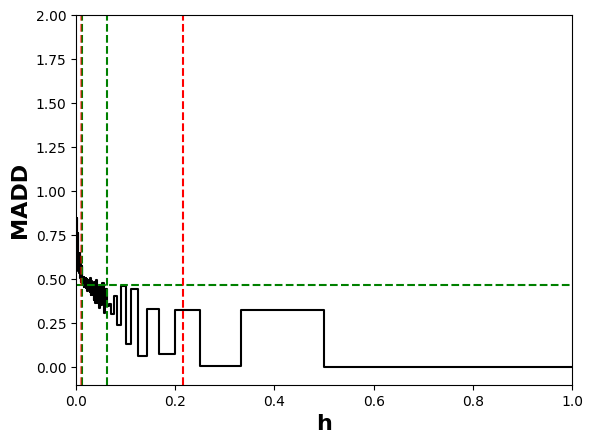

In [61]:
plot_stable_interval(e, madd, indexes=result_stable["indexes"], n0=n0, n1=n1, legend=False, show_order=True)

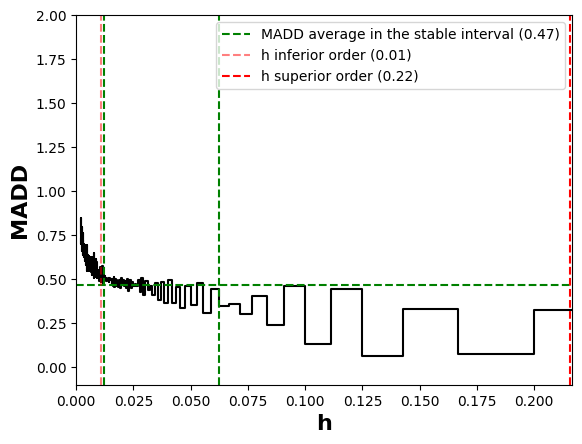

In [62]:
plot_stable_interval(e, madd, indexes=result_stable["indexes"], show_order=True, n0=n0, n1=n1, zoom="sup order")

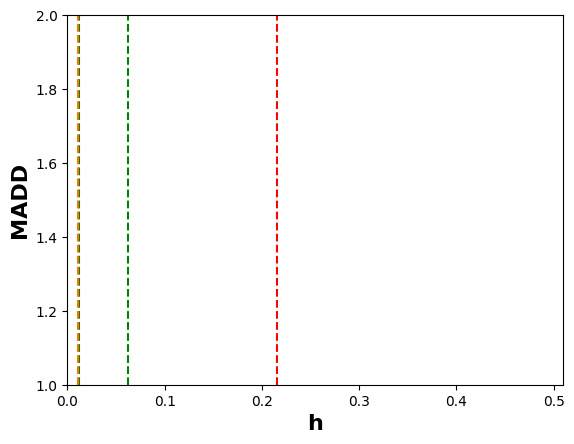

In [63]:
plot_stable_interval(e, madd, indexes=result_stable["indexes"], n0=n0, n1=n1, 
                     zoom=(0, 0.51), legend=False, show_order=True, ylim=(1, 2))

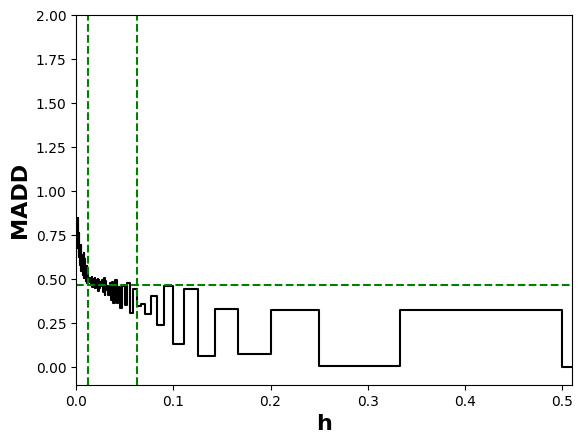

In [64]:
plot_stable_interval(e, madd, indexes=result_stable["indexes"], n0=n0, n1=n1, 
                     zoom=(0, 0.51), legend=False)